Train everything (reco, classifier, regressor) together. This seems to be more complicated, since it requires careful adjustment of the loss weights for the respective heads. When one of the heads has too much influence on the training process, the other objectives won't be trained (or will be trained very slowly).

[39. 26.]


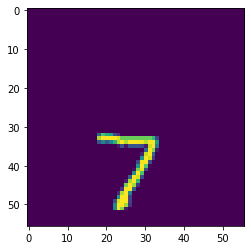

In [3]:
import sys; sys.path.insert(0, '..')
import utils
import keras
import numpy as np

def embed_and_translate(data, nrows, ncols):
    ndata = np.zeros((len(data), nrows, ncols, 1), dtype='float32')
    translations = np.empty((len(data), 2), dtype='float32')
    width, height = data.shape[1], data.shape[2]
    for i in range(len(data)):
        x = np.random.randint(ncols-width+1)
        y = np.random.randint(nrows-height+1)
        ndata[i][x:x+width, y:y+height] = data[i] # rows, cols = height, width
        translations[i][0] = x+(width//2)
        translations[i][1] = y+(height//2)
    return ndata, translations
            
n_splits = 16
io_shape = (56,56,1)
size = int(io_shape[0] // (n_splits**(1/2)))
latent_dim = 16 * 4 # since we have 4x4-splits we need 4 times the latent space for a fair comparison.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
x_train_augmented, y_train_regr = embed_and_translate(x_train, 56, 56)
x_train_split = np.array([utils.split(x, size, size) for x in x_train_augmented], dtype='float32')
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
x_test_augmented, y_test_regr = embed_and_translate(x_test, 56, 56)
x_test_split = np.array([utils.split(x, size, size) for x in x_test_augmented], dtype='float32')
y_test = keras.utils.to_categorical(y_test)

In [16]:
from keras.layers import Flatten, Conv2D, Conv2DTranspose, Dense, Input, Reshape, concatenate, Activation, Dropout
from keras import Sequential
from keras.models import Model

import tensorflow as tf
import keras
import sys; sys.path.insert(0, '..')
import utils

class MultiSplit(Model):
    def __init__(self, n_splits, latent_dim, io_shape):
        super(MultiSplit, self).__init__()
        n_filters = [32, 64]
        size = int( io_shape[0] // (n_splits**(1/2)) )  # W = H
        self.encoder = self._create_encoder(latent_dim//n_splits, (size, size,1), n_filters)
        self.input_reshaper = utils.Reshaper((n_splits, size, size, 1), (size, size,1))
        self.latent_reshaper = utils.Reshaper([latent_dim//n_splits], [latent_dim])
        self.regressor = self._create_regressor(latent_dim)
        self.classifier = self._create_classifier(latent_dim)
        self.decoder = self._create_decoder(latent_dim, io_shape, n_filters)
        
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x)
            loss = self.compiled_loss(y, y_pred)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, y = data
        y_pred = self(x, training=False)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
    
    def call(self, x, training=True):
        z = self.encode(x, training=training)
        y_reco = self.decode(z ,training=training)
        y_class = self.classify(z ,training=training)
        y_regr = self.regress(z ,training=training)
        return {"decoder_out": y_reco, "classifier_out": y_class, "regressor_out": y_regr}
        
    def encode(self, x, training=True):
        return self.encoder( self.input_reshaper(x) , training)
    
    def decode(self, z, training=True):
        return self.decoder( self.latent_reshaper(z) , training)
    
    def classify(self, z, training=True):
        return self.classifier( self.latent_reshaper(z) , training)
    
    def regress(self, z, training=True):
        return self.regressor( self.latent_reshaper(z) , training)
    
    def _create_encoder(self, latent_dim, input_shape, n_filters):
        return Sequential([
            Input(shape=input_shape),
            Conv2D(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2D(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Flatten(),
            Dense(units=latent_dim, activation='sigmoid')
        ], name='encoder')

    def _create_decoder(self, latent_dim, io_shape, n_filters):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(io_shape[0]//4 * io_shape[1]//4 * 8),
            Reshape((io_shape[0]//4, io_shape[1]//4, 8)),
            Conv2DTranspose(filters=n_filters[1], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=n_filters[0], kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'),
            Conv2DTranspose(filters=1, kernel_size=(3,3), padding='same'),
            Activation('sigmoid', name='decoder_out')
        ])
    
    def _create_classifier(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax', name='classifier_out')
        ])
    
    def _create_regressor(self, latent_dim):
        return Sequential([
            Input(shape=(latent_dim)),
            Dense(64, activation='elu'),
            Dense(64, activation='elu'),
            Dense(2, activation='linear', name='regressor_out')
        ])

In [17]:
losses = {
    'decoder_out' : 'mse',
    'classifier_out' : 'categorical_crossentropy',
    'regressor_out' : 'mean_absolute_percentage_error'
}
loss_weights = {
    'decoder_out' : 1.0,
    'classifier_out' : 0.05,
    'regressor_out' : 0.01
}
model = MultiSplit(n_splits, latent_dim, io_shape)
model.compile(loss=losses, loss_weights=loss_weights, optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train_split, {'decoder_out': x_train_augmented, 'classifier_out': y_train, 'regressor_out': y_train_regr},
                    validation_data=(x_test_split, {'decoder_out': x_test_augmented, 'classifier_out': y_test, 'regressor_out':y_test_regr}),
                    epochs=25, batch_size=32)

Epoch 1/25
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2464 - classifier_out_loss: 2.1432 - decoder_out_loss: 0.0207 - regressor_out_loss: 11.8536 - classifier_out_accuracy: 0.1927 - decoder_out_accuracy: 0.9509 - regressor_out_accuracy: 0.8296 - val_loss: 0.1418 - val_classifier_out_loss: 1.8774 - val_decoder_out_loss: 0.0134 - val_regressor_out_loss: 3.4513 - val_classifier_out_accuracy: 0.2913 - val_decoder_out_accuracy: 0.9467 - val_regressor_out_accuracy: 0.9646
Epoch 2/25
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1262 - classifier_out_loss: 1.7199 - decoder_out_loss: 0.0127 - regressor_out_loss: 2.7464 - classifier_out_accuracy: 0.3569 - decoder_out_accuracy: 0.9468 - regressor_out_accuracy: 0.9679 - val_loss: 0.1167 - val_classifier_out_loss: 1.6007 - val_decoder_out_loss: 0.0123 - val_regressor_out_loss: 2.4398 - val_classifier_out_accuracy: 0.3973 - val_decoder_out_accuracy: 0.9474 - val_regressor_out_accuracy: 0.9546
Epoch 3

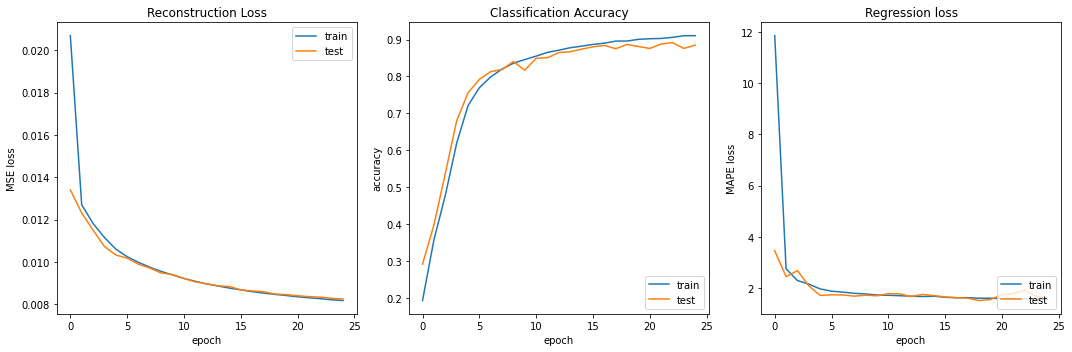

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].set_title('Reconstruction Loss')
axes[0].plot(history.history['decoder_out_loss'])
axes[0].plot(history.history['val_decoder_out_loss'])
axes[0].set_ylabel('MSE loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'test'], loc='upper right')

axes[1].set_title('Classification Accuracy')
axes[1].plot(history.history['classifier_out_accuracy'])
axes[1].plot(history.history['val_classifier_out_accuracy'])
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'test'], loc='lower right')

axes[2].set_title('Regression loss')
axes[2].plot(history.history['regressor_out_loss'])
axes[2].plot(history.history['val_regressor_out_loss'])
axes[2].set_ylabel('MAPE loss')
axes[2].set_xlabel('epoch')
axes[2].legend(['train', 'test'], loc='lower right')

fig.tight_layout()
# fig.show()
fig.savefig('../img/36/CE4x16_reco1_classify0.01_regress0.01.png')

Alternatively, train regressor on 16-split pretrained with classifier+reco.

In [10]:
model = MultiSplit(n_splits, latent_dim, io_shape)

model.encoder.load_weights('../weights/34_CAE4x16_encoder_epoch100.h5')
model.classifier.load_weights('../weights/34_CAE4x16_classifier_head_epoch100.h5')
model.decoder.load_weights('../weights/34_CAE4x16_decoder_head_epoch100.h5')
for layer in model.encoder.layers:
    layer.trainable = False
for layer in model.classifier.layers:
    layer.trainable = False
for layer in model.decoder.layers:
    layer.trainable = False

model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
history = model.fit(x_train_split, {'regressor_out': y_train_regr}, validation_data=(x_test_split, {'regressor_out':y_test_regr}), epochs=100, batch_size=32)

Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 8.9216 - classifier_out_loss: 0.0000e+00 - decoder_out_loss: 0.0000e+00 - regressor_out_loss: 8.9216 - val_loss: 4.1276 - val_classifier_out_loss: 0.0000e+00 - val_decoder_out_loss: 0.0000e+00 - val_regressor_out_loss: 4.1276
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 3.5307 - classifier_out_loss: 0.0000e+00 - decoder_out_loss: 0.0000e+00 - regressor_out_loss: 3.5307 - val_loss: 2.8800 - val_classifier_out_loss: 0.0000e+00 - val_decoder_out_loss: 0.0000e+00 - val_regressor_out_loss: 2.8800
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.5548 - classifier_out_loss: 0.0000e+00 - decoder_out_loss: 0.0000e+00 - regressor_out_loss: 2.5548 - val_loss: 2.2645 - val_classifier_out_loss: 0.0000e+00 - val_decoder_out_loss: 0.0000e+00 - val_regressor_out_loss: 2.2645
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.1781 - class

In [11]:
model.regressor.save_weights('../weights/36_CAE4x16_regressor_head_epoch100.h5')

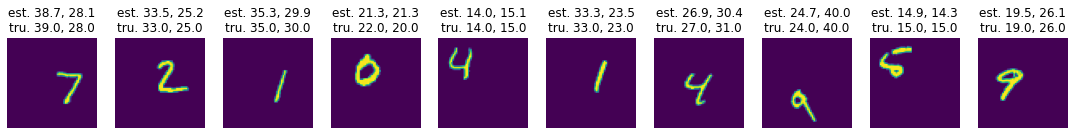

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf

z = model.encode(x_test_split[:1000], training=False)
y = model.regress(z, training=False)
n = 10
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est. {:3.1f}, {:3.1f}\ntru. {:3.1f}, {:3.1f}".format(y[i][1], y[i][0], y_test_regr[i][1], y_test_regr[i][0]))
    plt.imshow(x_test_augmented[i].reshape(56,56))

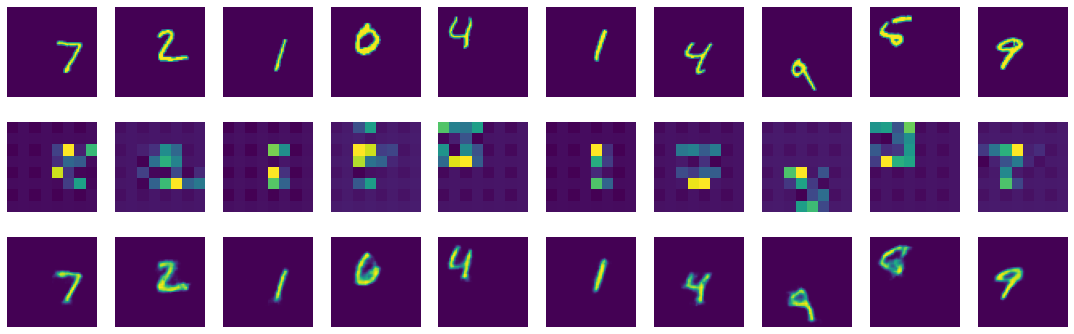

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 10
plt.figure(figsize=(19, 6))
for i in range(n):
    
    # predict
    x = x_test_split[i].reshape(1,16,14,14,1)
    z = model.encode(x, training=False)
    y = model.decode(z, training=False)
    
    ax = plt.subplot(3, n, i+1)
    plt.axis('off')
    plt.imshow(x_test_augmented[i].reshape(56,56))
    
    a = np.empty((8,8))
    for j in range(16):
        r = int(j/4)
        c = j%4
        a[r*2:(r+1)*2, c*2:(c+1)*2] = tf.reshape(z[j], (2,2))
    ax = plt.subplot(3, n, n+i+1) 
    plt.axis('off')
    plt.imshow(a)
    
    ax = plt.subplot(3, n, 2*n+i+1) 
    plt.axis('off')
    plt.imshow(tf.reshape(y, (56,56)))

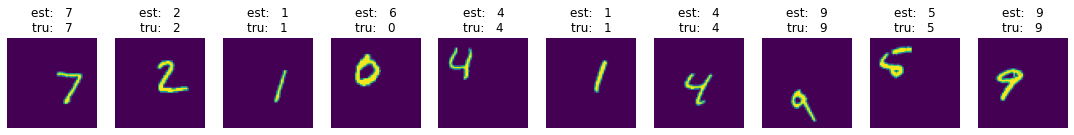

In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf

z = model.encode(x_test_split[:1000], training=False)
y = model.classify(z, training=False)
n = 10
plt.figure(figsize=(19, 6))
for i in range(n):
    
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.title("est: {:3.0f}\ntru: {:3.0f}".format(np.argmax(y[i]), np.argmax(y_test[i])))
    plt.imshow(x_test_augmented[i].reshape(56,56))